In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from tqdm import tqdm
import seaborn as sns
from implicit.nearest_neighbours import bm25_weight
from implicit.als import AlternatingLeastSquares
from implicit.bpr import BayesianPersonalizedRanking
from implicit.lmf import LogisticMatrixFactorization

/Users/tirsin/Documents/neuefische/fashion_recommender/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# import transactions, customer and article data
df_trans = pd.read_csv('../data/h-and-m-personalized-fashion-recommendations/transactions_train.csv', parse_dates=[0], dtype={'article_id':'string'})
df_art = pd.read_csv('../data/h-and-m-personalized-fashion-recommendations/articles.csv', dtype={'article_id':'string'})
df_customers = pd.read_csv('../data/h-and-m-personalized-fashion-recommendations/customers.csv')

In [3]:
# exclude parts of the data to reduce computational expense
# test period
#df = df_trans.query('t_dat <= "2020-09-15"').copy()
#
df = df_trans.query('(t_dat >= "2018-09-01" and t_dat < "2018-10-01") or (t_dat >= "2019-09-01" and t_dat < "2019-10-01")').copy()
#df = df_trans.copy()

# exclude users with less than 5 items in history
#n_items_per_user = df.groupby('customer_id').count().article_id.rename('n_items')
#df['n_items'] = df.customer_id.map(n_items_per_user)
#df = df[df.loc[:, 'n_items'] > 4]

# keep only users that have bought between 10 and 90 % of their items online
#n_items_per_channel = df.groupby(['customer_id', 'sales_channel_id']).count().article_id
#tmp1 = n_items_per_channel.reset_index().query('sales_channel_id == 1').set_index('customer_id').article_id.rename('offline_items')
#tmp2 = n_items_per_channel.reset_index().query('sales_channel_id == 2').set_index('customer_id').article_id.rename('online_items')
#online_fac = pd.concat([tmp1, tmp2], axis=1).fillna(0.0)
#online_fac['online_fac'] = online_fac.online_items/(online_fac.online_items + online_fac.offline_items)
#df['online_fac'] = df.customer_id.map(online_fac.online_fac).fillna(0.0)
#df = df.query('online_fac > 0.1 and online_fac < 0.9').copy()

In [4]:
df.customer_id.nunique()

333333

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1821954 entries, 0 to 17345071
Data columns (total 5 columns):
 #   Column            Dtype         
---  ------            -----         
 0   t_dat             datetime64[ns]
 1   customer_id       object        
 2   article_id        string        
 3   price             float64       
 4   sales_channel_id  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1), string(1)
memory usage: 83.4+ MB


In [6]:
# compute user-item interactions
df_int = df.groupby(['customer_id', 'article_id']).t_dat.count().reset_index()
df_int.rename(columns={'t_dat':'interactions'}, inplace=True)
df_int

,customer_id,article_id,interactions
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0656719005,1
1,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0797065001,2
2,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0521269001,1
3,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0583558001,2
4,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0639677008,1
...,...,...,...
1601835,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0671695001,1
1601836,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0568597019,1
1601837,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0573716012,1
1601838,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0781613006,1


In [7]:
n_users = df_int.customer_id.nunique()
n_items = df_int.article_id.nunique()
n_records = len(df)
print(f'Sample size: {n_users} user and {n_items} items in {n_records} transactions.')
print(f'Sum of interactions: {df_int.interactions.sum()}')

Sample size: 333333 user and 49805 items in 1821954 transactions.
Sum of interactions: 1821954


In [8]:
# create utility matrix Y
# rows represent items, columns represent users
# note: users with no transactions and items never sold are not included
n_users = df_int.customer_id.nunique()
n_items = df_int.article_id.nunique()
user_ids = df_int.customer_id.unique()
item_ids = df_int.article_id.unique()

item_id_map = dict([(item_id, i) for i, item_id in enumerate(item_ids)])
item_id_map_rev = dict([(i, item_id) for i, item_id in enumerate(item_ids)])
user_id_map = dict([(user_id, j) for j, user_id in enumerate(user_ids)])
user_id_map_rev = dict([(j, user_id) for j, user_id in enumerate(user_ids)])

df_int['i'] = df_int.article_id.apply(lambda id: item_id_map[id])
df_int['j'] = df_int.customer_id.apply(lambda id: user_id_map[id])

# create sparse matrix
Y = coo_matrix((df_int.interactions, (df_int['i'], df_int['j'])), shape=(n_items,n_users))
Y = bm25_weight(Y, K1=100, B=0.8)
Y_csr = Y.T.tocsr()


In [9]:
# check sparsity ratio
n_total = Y.shape[0]*Y.shape[1]
n_ratings = Y.nnz
sparsity = n_ratings/n_total
print('Matrix sparsity: ', round(sparsity*100, 2))

Matrix sparsity:  0.01


In [12]:
# best results so far: 1280 factors
model_als = AlternatingLeastSquares(factors=640, regularization=0.05, num_threads=0, iterations=30)
model_als.fit(2 * Y_csr)

/Users/tirsin/Documents/neuefische/fashion_recommender/.venv/lib/python3.9/site-packages/implicit/utils.py:26: UserWarning: OpenBLAS detected. Its highly recommend to set the environment variable 'export OPENBLAS_NUM_THREADS=1' to disable its internal multithreading
  warnings.warn(
100%|██████████| 30/30 [53:02<00:00, 106.08s/it]


In [11]:
model_bayesian = BayesianPersonalizedRanking(factors=640, regularization=0.05, num_threads=0, iterations=30, learning_rate=0.5)
model_bayesian.fit(Y_csr)

100%|██████████| 30/30 [01:02<00:00,  2.10s/it, train_auc=97.08%, skipped=0.18%]


In [11]:
model_bayesian_factor_1280 = BayesianPersonalizedRanking(factors=1280, regularization=0.05, num_threads=0, iterations=30, learning_rate=0.5)
model_bayesian_factor_1280.fit(Y_csr)

100%|██████████| 30/30 [02:49<00:00,  5.64s/it, train_auc=97.04%, skipped=0.18%]


In [20]:
model_logistic = LogisticMatrixFactorization(factors=640, regularization=0.05, num_threads=0, iterations=50, learning_rate=0.1)
model_logistic.fit(Y_csr)

100%|██████████| 50/50 [1:17:40<00:00, 93.21s/it] 


In [21]:
# predict full batch of users
user_idx = [user_id_map[id] for id in user_ids]
ids, scores = model_logistic.recommend(user_idx, Y_csr[user_idx], N=12, filter_already_liked_items=False)

In [12]:
# predict full batch of users
user_idx = [user_id_map[id] for id in user_ids]
ids, scores = model_bayesian_factor_1280.recommend(user_idx, Y_csr[user_idx], N=12, filter_already_liked_items=False)

In [22]:
len(user_idx)

333333

In [23]:
# convert from matrix indices to item ids
tmp = pd.DataFrame(ids, index=user_ids)
tmp = tmp.apply(lambda s: ' '.join(s.apply(lambda id: item_id_map_rev[id])), axis=1)

In [24]:
tmp.head()

00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657    0546807001 0449099043 0737710005 0560214003 05...
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa    0798579002 0565379005 0657434007 0703389001 06...
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318    0783388001 0426013023 0324502008 0800895001 06...
00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2    0603145014 0717479002 0785327002 0718370001 07...
00009d946eec3ea54add5ba56d5210ea898def4b46c68570cf0096d962cacc75    0665329002 0691177002 0750565002 0730687001 06...
dtype: object

In [25]:
# make frame containing all available individualized recommendations and join with customer table
submission = pd.DataFrame({'prediction':tmp}, index=user_ids)
submission = df_customers.join(submission, on='customer_id', how='left').set_index('customer_id')
# now fill empty predictions with baseline
baseline_prediction = '0706016001 0706016002 0372860001 0610776002 0759871002 0464297007 0372860002 0610776001 0399223001 0706016003 0720125001 0156231001'
submission.fillna(baseline_prediction, inplace=True)


In [26]:
submission.head()

,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,prediction
customer_id,,,,,,,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,0706016001 0706016002 0372860001 0610776002 07...,0706016001 0706016002 0372860001 0610776002 07...,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...,0546807001 0449099043 0737710005 0560214003 05...
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,0706016001 0706016002 0372860001 0610776002 07...,0706016001 0706016002 0372860001 0610776002 07...,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...,0798579002 0565379005 0657434007 0703389001 06...
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,0706016001 0706016002 0372860001 0610776002 07...,0706016001 0706016002 0372860001 0610776002 07...,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,0783388001 0426013023 0324502008 0800895001 06...
00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e,0706016001 0706016002 0372860001 0610776002 07...,0706016001 0706016002 0372860001 0610776002 07...,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...,0706016001 0706016002 0372860001 0610776002 07...
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...,0706016001 0706016002 0372860001 0610776002 07...


In [27]:
submission.prediction[0]

'0546807001 0449099043 0737710005 0560214003 0564358046 0780418001 0507910001 0733098014 0741087001 0782880005 0785948007 0702757002'

In [28]:
submission.loc[:, 'prediction'].to_csv('../data/sinan_logistic.csv')

In [17]:
# pick any article
article_id = item_ids[37000]
article_name = df_art.query('article_id == @article_id').prod_name.values[0]
print(article_name)

JESSY SKIRT


In [18]:
similar_items = item_predictions.loc[article_id].prediction.split(' ') 

NameError: name 'item_predictions' is not defined

In [22]:
item_names = dict(zip(df_art.article_id, df_art.prod_name))

NameError: name 'similar_items' is not defined

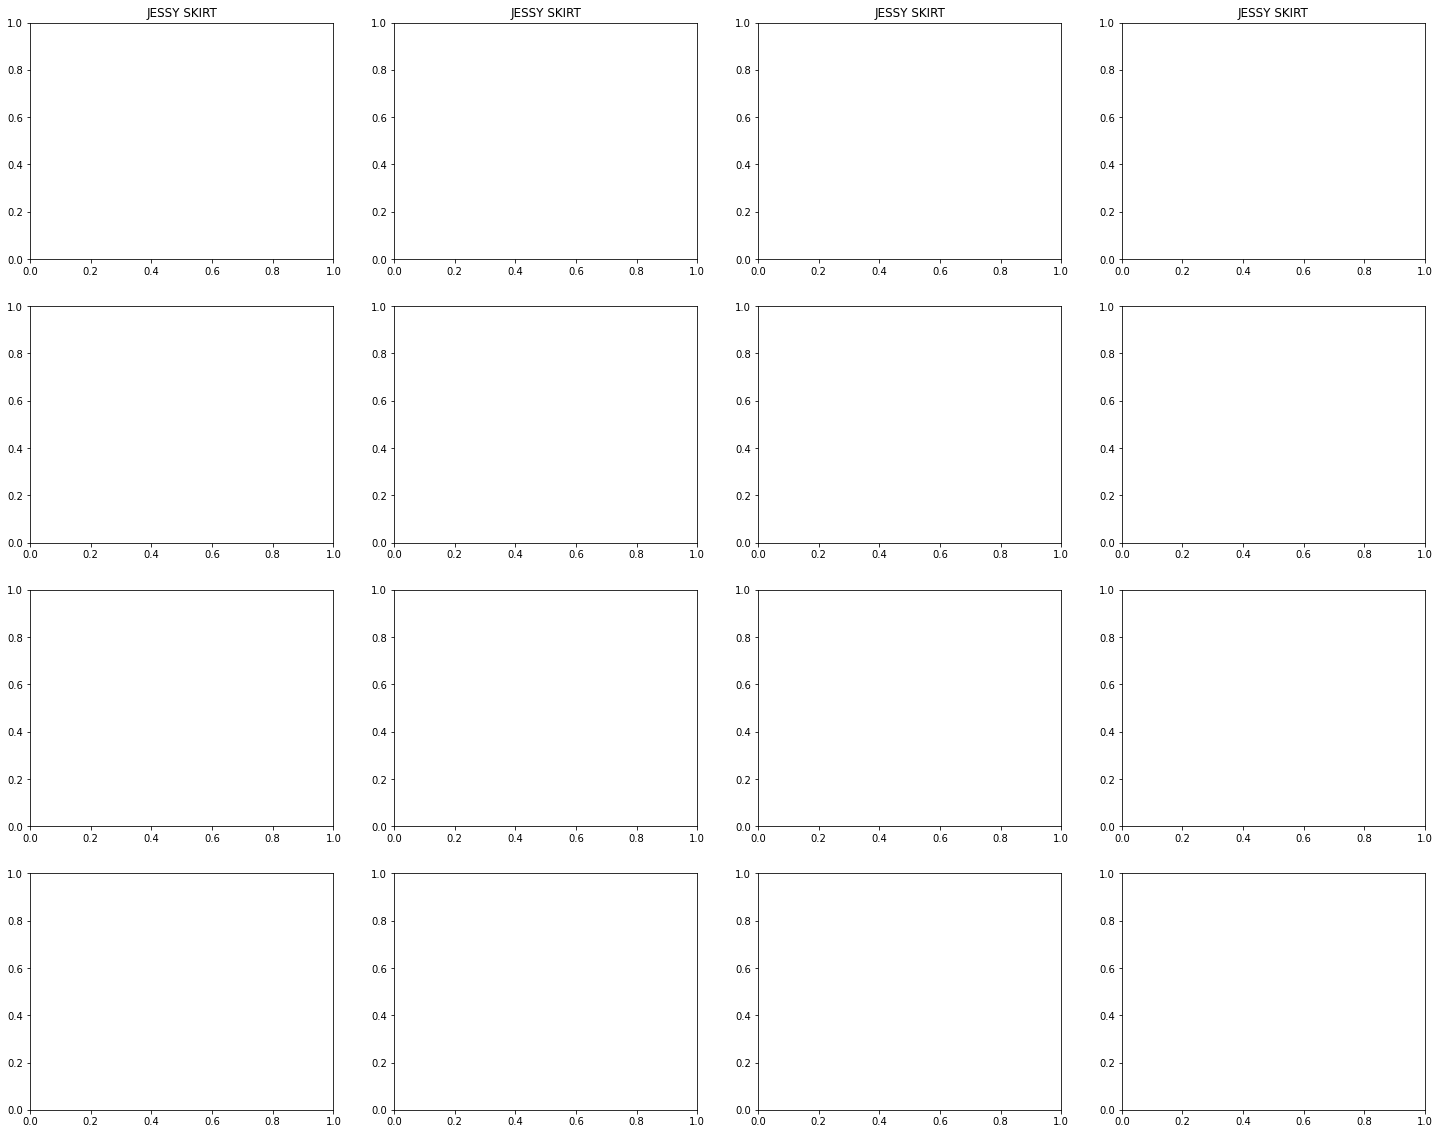

In [21]:
# display results
fig, axs = plt.subplots(4, 4, figsize=(25, 20))
c = 0
for i in range(4):
    for j in range(4):
        ax = axs[i][j]
        if i == 0:
            ax.set_title(article_name)
            fname = article_id + '.jpg'
            subdir = fname[0:3]
            full_path = os.path.join('../data', 'images', subdir, fname)
        else:
            fname = similar_items[c] + '.jpg'
            subdir = fname[0:3]
            full_path = os.path.join('../data', 'images', subdir, fname)
            ax.set_title(item_names[similar_items[c]])
            c += 1
         
        if os.path.exists(full_path):
            img = mpimg.imread(full_path)
            ax.imshow(img)

In [65]:
sub1 = pd.read_csv('../data/cf-item-item-1000-users_submission.csv', index_col=0)

In [67]:
sub1.query('prediction == ""').head()

,prediction
customer_id,
